# Notebook 2: XGBoost Training & Comparison
Trains XGBoost on each descriptor CSV from Notebook 1.
Compares R2, MAE, RMSE across all scenarios.

**CSV naming convention:**
- `desc_{TYPE}_w{WINDOW}.csv` for individual types per window
- `desc_ALL_w{WINDOW}.csv` for all types combined per window
- `desc_ALL_multiwindow.csv` for all types across all windows

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import warnings
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# ============================================================
# PATHS
# ============================================================
BASE_DIR = r"C:\Users\AbCMS_Lab\Desktop\Keshav-DDP"
CSV_DIR = os.path.join(BASE_DIR, "Weight-contribution", "contribution-model")

# Find all descriptor CSVs
csv_files = sorted(glob.glob(os.path.join(CSV_DIR, "desc_*.csv")))
print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    name = os.path.basename(f)
    df_tmp = pd.read_csv(f)
    feat_cols = [c for c in df_tmp.columns if c not in 
                 ['uid','Formula','alpha_R','heavy1_el','heavy2_el','heavy1_mass',
                  'heavy2_mass','n_elements','window']]
    print(f"  {name}: {len(df_tmp)} rows, {len(feat_cols)} features")

Found 36 CSV files:
  desc_ALL_multiwindow.csv: 99 rows, 72 features
  desc_ALL_w005.csv: 99 rows, 18 features
  desc_ALL_w01.csv: 99 rows, 18 features
  desc_ALL_w05.csv: 99 rows, 18 features
  desc_ALL_w10.csv: 99 rows, 18 features
  desc_A_w005.csv: 99 rows, 2 features
  desc_A_w01.csv: 99 rows, 2 features
  desc_A_w05.csv: 99 rows, 2 features
  desc_A_w10.csv: 99 rows, 2 features
  desc_B_w005.csv: 99 rows, 2 features
  desc_B_w01.csv: 99 rows, 2 features
  desc_B_w05.csv: 99 rows, 2 features
  desc_B_w10.csv: 99 rows, 2 features
  desc_C_w005.csv: 99 rows, 4 features
  desc_C_w01.csv: 99 rows, 4 features
  desc_C_w05.csv: 99 rows, 4 features
  desc_C_w10.csv: 99 rows, 4 features
  desc_D_w005.csv: 99 rows, 4 features
  desc_D_w01.csv: 99 rows, 4 features
  desc_D_w05.csv: 99 rows, 4 features
  desc_D_w10.csv: 99 rows, 4 features
  desc_E_enhanced_w05.csv: 99 rows, 19 features
  desc_E_enhanced_w05_w10.csv: 99 rows, 31 features
  desc_E_enhanced_w10.csv: 99 rows, 19 features
  desc

In [3]:
# ============================================================
# TRAINING FUNCTION
# ============================================================

# Columns to exclude from features
NON_FEATURE_COLS = {'uid', 'Formula', 'alpha_R', 'heavy1_el', 'heavy2_el',
                     'heavy1_mass', 'heavy2_mass', 'n_elements', 'window'}

def train_and_evaluate(csv_path, n_splits=5):
    """
    Train XGBoost on a descriptor CSV.
    Uses K-Fold CV (and LOO if n < 30).
    Returns dict with metrics.
    """
    df = pd.read_csv(csv_path)
    csv_name = os.path.basename(csv_path)
    
    # Identify feature columns (numeric only, not metadata)
    feature_cols = [c for c in df.columns if c not in NON_FEATURE_COLS]
    # Keep only numeric
    feature_cols = [c for c in feature_cols if df[c].dtype in ['float64','float32','int64','int32']]
    
    if len(feature_cols) == 0:
        return {'csv': csv_name, 'error': 'no features'}
    
    X = df[feature_cols].values
    y = df['alpha_R'].values
    n = len(y)
    
    # Drop rows with NaN
    valid = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[valid], y[valid]
    n = len(y)
    
    if n < 10:
        return {'csv': csv_name, 'error': f'too few samples ({n})'}
    
    # XGBoost with modest params for small dataset
    model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    )
    
    results = {
        'csv': csv_name,
        'n_samples': n,
        'n_features': len(feature_cols),
        'features': feature_cols,
    }
    
    # --- K-Fold CV ---
    k = min(n_splits, n)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    y_pred_kf = np.zeros(n)
    for train_idx, test_idx in kf.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred_kf[test_idx] = model.predict(X[test_idx])
    
    results['kfold_R2'] = r2_score(y, y_pred_kf)
    results['kfold_MAE'] = mean_absolute_error(y, y_pred_kf)
    results['kfold_RMSE'] = np.sqrt(mean_squared_error(y, y_pred_kf))
    
    # --- LOO CV (if small dataset) ---
    if n <= 120:
        loo = LeaveOneOut()
        y_pred_loo = np.zeros(n)
        for train_idx, test_idx in loo.split(X):
            model.fit(X[train_idx], y[train_idx])
            y_pred_loo[test_idx] = model.predict(X[test_idx])
        
        results['loo_R2'] = r2_score(y, y_pred_loo)
        results['loo_MAE'] = mean_absolute_error(y, y_pred_loo)
        results['loo_RMSE'] = np.sqrt(mean_squared_error(y, y_pred_loo))
    else:
        results['loo_R2'] = np.nan
        results['loo_MAE'] = np.nan
        results['loo_RMSE'] = np.nan
    
    # --- Feature importance (train on full data) ---
    model.fit(X, y)
    results['feature_importance'] = dict(zip(feature_cols, model.feature_importances_))
    results['train_R2'] = r2_score(y, model.predict(X))
    
    return results

In [4]:
# ============================================================
# RUN ON ALL CSVs
# ============================================================
all_results = []

for csv_path in csv_files:
    name = os.path.basename(csv_path)
    print(f"Training on {name}...", end=" ")
    res = train_and_evaluate(csv_path)
    all_results.append(res)
    
    if 'error' in res:
        print(f"SKIPPED: {res['error']}")
    else:
        loo_val = res.get('loo_R2', None)
        loo_str = f"{loo_val:.3f}" if isinstance(loo_val, float) and not np.isnan(loo_val) else "N/A"
        print(f"KFold R2={res['kfold_R2']:.3f}, LOO R2={loo_str}, "
              f"n={res['n_samples']}, feats={res['n_features']}")

print("\nDone!")


Training on desc_ALL_multiwindow.csv... KFold R2=0.332, LOO R2=0.322, n=99, feats=72
Training on desc_ALL_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=18
Training on desc_ALL_w01.csv... KFold R2=-0.026, LOO R2=-0.024, n=99, feats=18
Training on desc_ALL_w05.csv... KFold R2=0.331, LOO R2=0.326, n=99, feats=18
Training on desc_ALL_w10.csv... KFold R2=0.374, LOO R2=0.403, n=99, feats=18
Training on desc_A_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=2
Training on desc_A_w01.csv... KFold R2=-0.025, LOO R2=-0.024, n=99, feats=2
Training on desc_A_w05.csv... KFold R2=-0.107, LOO R2=-0.083, n=99, feats=2
Training on desc_A_w10.csv... KFold R2=-0.499, LOO R2=-0.349, n=99, feats=2
Training on desc_B_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=2
Training on desc_B_w01.csv... KFold R2=-0.025, LOO R2=-0.024, n=99, feats=2
Training on desc_B_w05.csv... KFold R2=-0.172, LOO R2=-0.120, n=99, feats=2
Training on desc_B_w10.csv... KFold R2=-0.251, LOO R2=-0.302, n=99, 

In [5]:
# ============================================================
# ABLATION: Base p_frac + ONE elemental feature at a time
# ============================================================
# For each enhanced CSV, take the base p_frac columns,
# then add one elemental feature group at a time.

# Define elemental feature groups (each is a 'one addition')
ELEM_GROUPS = {
    'max_Z4':       ['max_Z4'],
    'max_Z':        ['max_Z'],
    'max_mass':     ['max_mass'],
    'X_diff':       ['X_diff'],
    'X_mean':       ['X_mean'],
    'radius_diff':  ['radius_diff'],
    'radius_mean':  ['radius_mean'],
    'WM':           ['WM_VBM', 'WM_CBM'],
    'WZ4':          ['WZ4_VBM', 'WZ4_CBM'],
    'pZ4':          ['pZ4_VBM', 'pZ4_CBM'],
    'Wr':           ['Wr_VBM', 'Wr_CBM'],
    'WX':           ['WX_VBM', 'WX_CBM'],
}

# Find enhanced CSVs
enhanced_csvs = [f for f in csv_files if 'enhanced' in os.path.basename(f)]
print(f"Enhanced CSVs found: {len(enhanced_csvs)}")
for f in enhanced_csvs:
    print(f"  {os.path.basename(f)}")

ablation_results = []

for csv_path in enhanced_csvs:
    csv_name = os.path.basename(csv_path)
    df = pd.read_csv(csv_path)
    
    # Identify base p_frac columns (handle renamed ones like E_pfrac_VBM_w05)
    base_cols = [c for c in df.columns if 'pfrac' in c.lower() or 'E_pfrac' in c]
    base_cols = [c for c in base_cols if df[c].dtype in ['float64','float32','int64','int32']]
    
    if not base_cols:
        print(f"  {csv_name}: No p_frac columns found, skipping")
        continue
    
    y = df['alpha_R'].values
    
    print(f"\n{'='*60}")
    print(f"{csv_name}")
    print(f"Base columns: {base_cols}")
    print(f"{'='*60}")
    
    # --- Baseline: just p_frac ---
    X_base = df[base_cols].values
    valid = ~(np.isnan(X_base).any(axis=1) | np.isnan(y))
    X_b, y_b = X_base[valid], y[valid]
    
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=1.0, reg_lambda=1.0, random_state=42, verbosity=0)
    
    y_pred_base = np.zeros(len(y_b))
    loo = LeaveOneOut()
    for tr, te in loo.split(X_b):
        model.fit(X_b[tr], y_b[tr])
        y_pred_base[te] = model.predict(X_b[te])
    
    base_r2 = r2_score(y_b, y_pred_base)
    base_mae = mean_absolute_error(y_b, y_pred_base)
    
    ablation_results.append({
        'csv': csv_name,
        'added': 'BASELINE (p_frac only)',
        'n_features': len(base_cols),
        'features': base_cols,
        'LOO_R2': base_r2,
        'LOO_MAE': base_mae,
        'delta_R2': 0.0,
    })
    print(f"  BASELINE: {len(base_cols)} feat, LOO R2={base_r2:.3f}, MAE={base_mae:.3f}")
    
    # --- Add one group at a time ---
    for grp_name, grp_cols in ELEM_GROUPS.items():
        # Check which columns exist (handle _w05/_w10 suffixes)
        available = []
        for gc in grp_cols:
            # Direct match
            if gc in df.columns:
                available.append(gc)
            else:
                # Try with window suffixes
                for suffix in ['_w05', '_w10']:
                    if gc + suffix in df.columns:
                        available.append(gc + suffix)
        
        if not available:
            continue
        
        # Check all numeric
        available = [c for c in available if df[c].dtype in ['float64','float32','int64','int32']]
        if not available:
            continue
        
        all_cols = base_cols + available
        X_aug = df[all_cols].values
        valid = ~(np.isnan(X_aug).any(axis=1) | np.isnan(y))
        X_a, y_a = X_aug[valid], y[valid]
        
        y_pred_aug = np.zeros(len(y_a))
        for tr, te in loo.split(X_a):
            model.fit(X_a[tr], y_a[tr])
            y_pred_aug[te] = model.predict(X_a[te])
        
        aug_r2 = r2_score(y_a, y_pred_aug)
        aug_mae = mean_absolute_error(y_a, y_pred_aug)
        delta = aug_r2 - base_r2
        
        marker = '+++' if delta > 0.05 else '++' if delta > 0.02 else '+' if delta > 0 else '--' if delta < -0.05 else '-' if delta < 0 else '='
        
        ablation_results.append({
            'csv': csv_name,
            'added': grp_name,
            'n_features': len(all_cols),
            'features': all_cols,
            'LOO_R2': aug_r2,
            'LOO_MAE': aug_mae,
            'delta_R2': delta,
        })
        print(f"  + {grp_name:<15} ({len(available)} col): LOO R2={aug_r2:.3f}, delta={delta:+.3f} {marker}")

print(f"\nTotal ablation runs: {len(ablation_results)}")


Enhanced CSVs found: 3
  desc_E_enhanced_w05.csv
  desc_E_enhanced_w05_w10.csv
  desc_E_enhanced_w10.csv

desc_E_enhanced_w05.csv
Base columns: ['E_pfrac_VBM', 'E_pfrac_CBM']
  BASELINE: 2 feat, LOO R2=0.398, MAE=0.557
  + max_Z4          (1 col): LOO R2=0.408, delta=+0.010 +
  + max_Z           (1 col): LOO R2=0.408, delta=+0.010 +
  + max_mass        (1 col): LOO R2=0.397, delta=-0.001 -
  + X_diff          (1 col): LOO R2=0.385, delta=-0.013 -
  + X_mean          (1 col): LOO R2=0.417, delta=+0.019 +
  + radius_diff     (1 col): LOO R2=0.427, delta=+0.029 ++
  + radius_mean     (1 col): LOO R2=0.490, delta=+0.092 +++
  + WM              (2 col): LOO R2=0.372, delta=-0.025 -
  + WZ4             (2 col): LOO R2=0.357, delta=-0.041 -
  + pZ4             (2 col): LOO R2=0.386, delta=-0.012 -
  + Wr              (2 col): LOO R2=0.425, delta=+0.027 ++
  + WX              (2 col): LOO R2=0.424, delta=+0.026 ++

desc_E_enhanced_w05_w10.csv
Base columns: ['E_pfrac_VBM_w05', 'E_pfrac_CBM_w05'

ABLATION RESULTS RANKED BY LOO R2
                        csv                  added  n_features  LOO_R2  LOO_MAE  delta_R2
    desc_E_enhanced_w10.csv            radius_mean           3   0.563    0.479     0.184
desc_E_enhanced_w05_w10.csv            radius_mean           5   0.497    0.500     0.012
desc_E_enhanced_w05_w10.csv                     Wr           8   0.491    0.484     0.005
    desc_E_enhanced_w05.csv            radius_mean           3   0.490    0.522     0.092
    desc_E_enhanced_w10.csv               max_mass           3   0.487    0.498     0.108
desc_E_enhanced_w05_w10.csv BASELINE (p_frac only)           4   0.485    0.512     0.000
    desc_E_enhanced_w10.csv                     Wr           4   0.485    0.497     0.106
    desc_E_enhanced_w10.csv                  max_Z           3   0.485    0.503     0.105
    desc_E_enhanced_w10.csv                 max_Z4           3   0.485    0.503     0.105
desc_E_enhanced_w05_w10.csv               max_mass           5   0

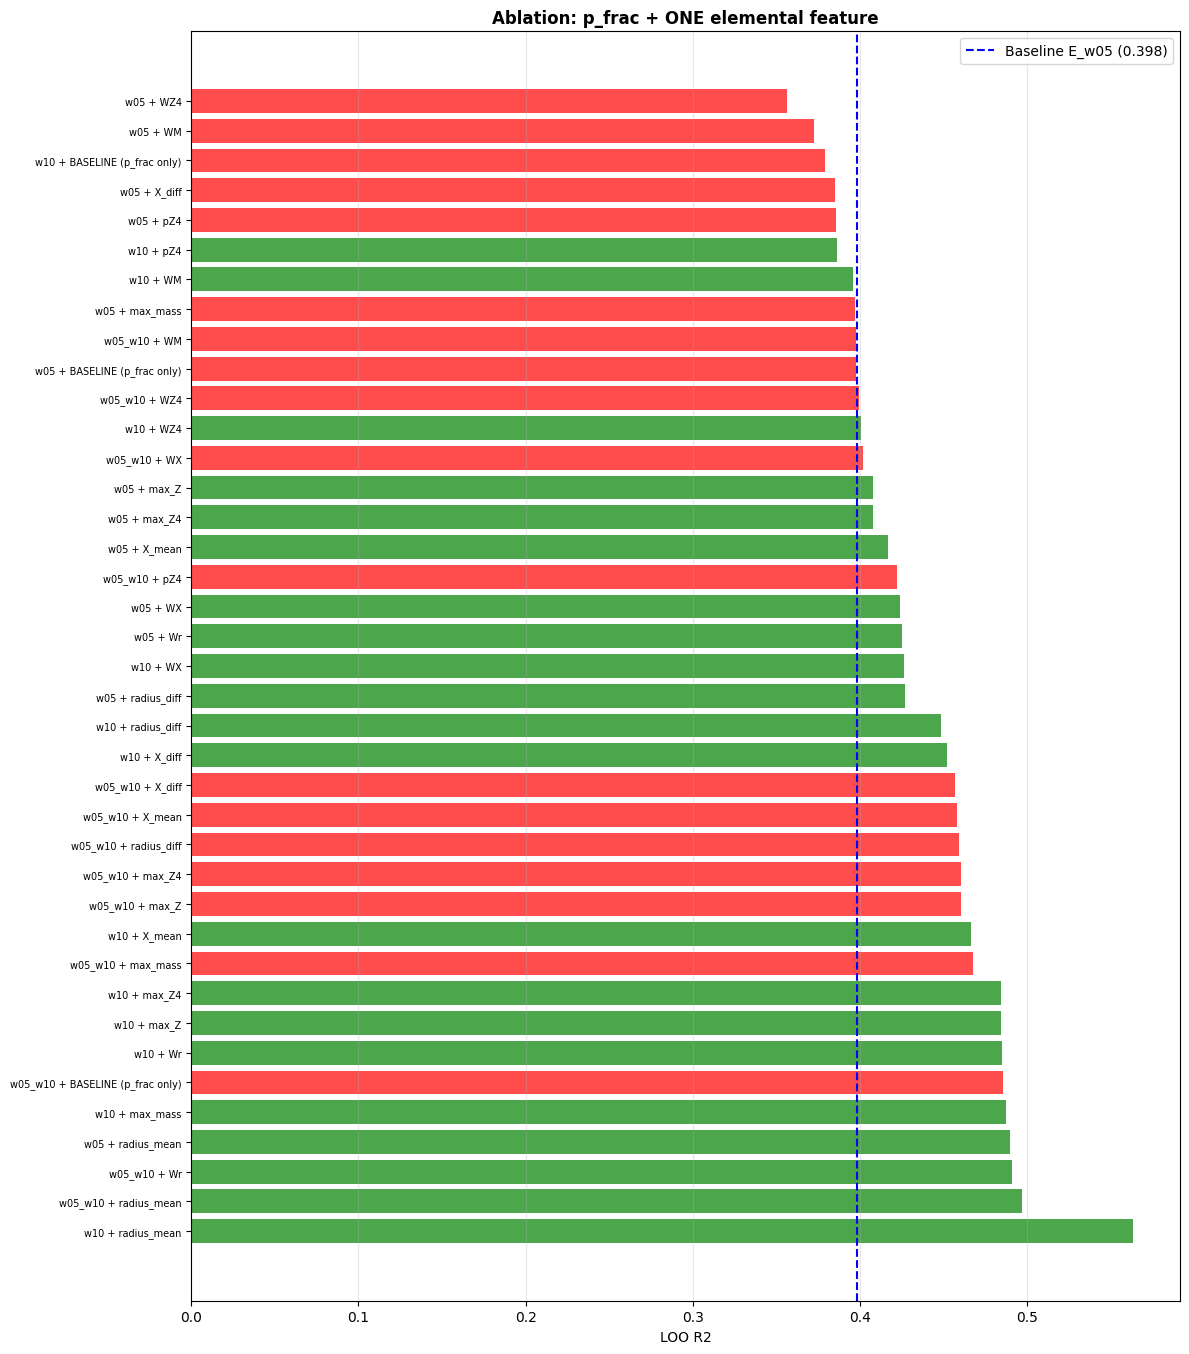

In [6]:
# ============================================================
# ABLATION SUMMARY: RANKED
# ============================================================
df_abl = pd.DataFrame(ablation_results)
df_abl = df_abl.sort_values('LOO_R2', ascending=False)

print('=' * 90)
print('ABLATION RESULTS RANKED BY LOO R2')
print('=' * 90)
print(df_abl[['csv','added','n_features','LOO_R2','LOO_MAE','delta_R2']].to_string(index=False, float_format='%.3f'))

# Save
abl_path = os.path.join(CSV_DIR, 'ablation_results.csv')
df_abl[['csv','added','n_features','LOO_R2','LOO_MAE','delta_R2']].to_csv(abl_path, index=False)
print(f'\nSaved to {abl_path}')

# Bar chart
fig, ax = plt.subplots(figsize=(12, max(4, len(df_abl)*0.35)))
colors = ['green' if d > 0 else 'red' for d in df_abl['delta_R2']]
labels = df_abl['csv'].str.replace('desc_E_enhanced_','').str.replace('.csv','') + ' + ' + df_abl['added']
ax.barh(range(len(df_abl)), df_abl['LOO_R2'], color=colors, alpha=0.7)
ax.set_yticks(range(len(df_abl)))
ax.set_yticklabels(labels, fontsize=7)
ax.axvline(x=0.398, color='blue', ls='--', lw=1.5, label='Baseline E_w05 (0.398)')
ax.set_xlabel('LOO R2')
ax.set_title('Ablation: p_frac + ONE elemental feature', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(CSV_DIR, 'ablation_chart.png'), dpi=150, bbox_inches='tight')
plt.show()


In [7]:
# ============================================================
# RESULTS SUMMARY TABLE
# ============================================================
summary_rows = []
for res in all_results:
    if 'error' in res:
        continue
    summary_rows.append({
        'CSV': res['csv'],
        'n': res['n_samples'],
        'features': res['n_features'],
        'train_R2': res['train_R2'],
        'KFold_R2': res['kfold_R2'],
        'KFold_MAE': res['kfold_MAE'],
        'KFold_RMSE': res['kfold_RMSE'],
        'LOO_R2': res.get('loo_R2', np.nan),
        'LOO_MAE': res.get('loo_MAE', np.nan),
    })

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values('KFold_R2', ascending=False)

print("=" * 100)
print("RESULTS RANKED BY KFold R2")
print("=" * 100)
print(df_summary.to_string(index=False, float_format='%.3f'))

# Save
summary_path = os.path.join(CSV_DIR, "results_summary.csv")
df_summary.to_csv(summary_path, index=False)
print(f"\nSaved to {summary_path}")

RESULTS RANKED BY KFold R2
                        CSV  n  features  train_R2  KFold_R2  KFold_MAE  KFold_RMSE  LOO_R2  LOO_MAE
    desc_E_enhanced_w05.csv 99        19     0.958     0.470      0.477       0.696   0.404    0.519
         desc_E_w05_w10.csv 99         4     0.914     0.452      0.500       0.708   0.485    0.512
             desc_E_w05.csv 99         2     0.809     0.448      0.534       0.711   0.398    0.557
           desc_ALL_w10.csv 99        18     0.965     0.374      0.493       0.757   0.403    0.492
    desc_E_enhanced_w10.csv 99        19     0.958     0.369      0.543       0.760   0.351    0.532
desc_E_enhanced_w05_w10.csv 99        31     0.966     0.350      0.526       0.771   0.371    0.537
             desc_E_w10.csv 99         2     0.805     0.341      0.562       0.777   0.379    0.564
   desc_ALL_multiwindow.csv 99        72     0.969     0.332      0.511       0.782   0.322    0.513
           desc_ALL_w05.csv 99        18     0.959     0.331    

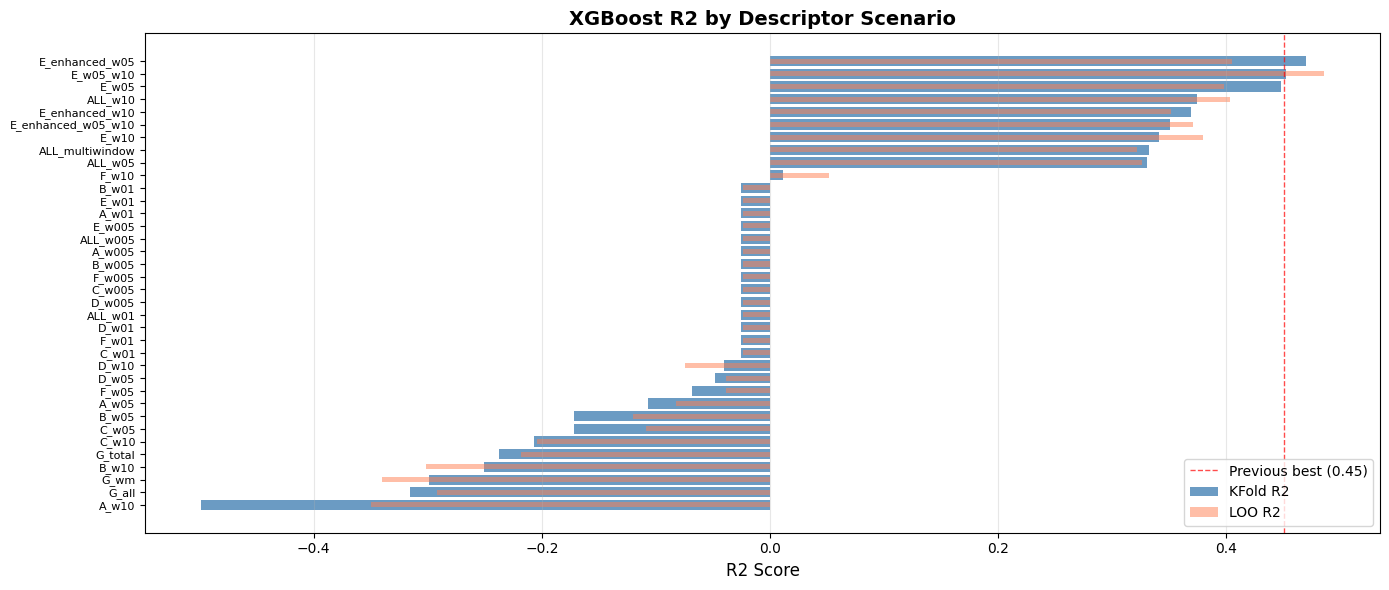

In [8]:
# ============================================================
# VISUALIZATION: R2 COMPARISON BAR CHART
# ============================================================
fig, ax = plt.subplots(figsize=(14, 6))

df_plot = df_summary.sort_values('KFold_R2', ascending=True)
y_pos = range(len(df_plot))

bars = ax.barh(y_pos, df_plot['KFold_R2'], color='steelblue', alpha=0.8, label='KFold R2')
if 'LOO_R2' in df_plot.columns:
    ax.barh(y_pos, df_plot['LOO_R2'], color='coral', alpha=0.5, height=0.4, label='LOO R2')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_plot['CSV'].str.replace('desc_', '').str.replace('.csv', ''), fontsize=8)
ax.set_xlabel('R2 Score', fontsize=12)
ax.set_title('XGBoost R2 by Descriptor Scenario', fontsize=14, fontweight='bold')
ax.axvline(x=0.45, color='red', ls='--', lw=1, alpha=0.7, label='Previous best (0.45)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(CSV_DIR, 'r2_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# ============================================================
# FEATURE IMPORTANCE FOR TOP 3 ABLATION MODELS
# ============================================================
df_abl_sorted = pd.DataFrame(ablation_results).sort_values('LOO_R2', ascending=False)

for idx in range(min(3, len(df_abl_sorted))):
    row = df_abl_sorted.iloc[idx]
    csv_path = os.path.join(CSV_DIR, row['csv'])
    feat_cols = row['features']
    
    df_data = pd.read_csv(csv_path)
    feat_cols = [c for c in feat_cols if c in df_data.columns]
    
    X = df_data[feat_cols].values
    y = df_data['alpha_R'].values
    valid = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[valid], y[valid]
    
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=1.0, reg_lambda=1.0, random_state=42, verbosity=0)
    model.fit(X, y)
    
    label = row['csv'].replace('desc_E_enhanced_','').replace('.csv','') + ' + ' + row['added']
    print(f"\n{'='*50}")
    print(f"Model #{idx+1}: {label} (LOO R2={row['LOO_R2']:.3f})")
    print(f"{'='*50}")
    fi = dict(zip(feat_cols, model.feature_importances_))
    for feat, imp in sorted(fi.items(), key=lambda x: x[1], reverse=True):
        bar = '|' * int(imp * 40)
        print(f"  {feat:<25} {imp:.3f} {bar}")



Model #1: w10 + radius_mean (LOO R2=0.563)
  E_pfrac_CBM               0.475 ||||||||||||||||||
  radius_mean               0.271 ||||||||||
  E_pfrac_VBM               0.254 ||||||||||

Model #2: w05_w10 + radius_mean (LOO R2=0.497)
  E_pfrac_CBM_w10           0.305 ||||||||||||
  E_pfrac_VBM_w05           0.197 |||||||
  E_pfrac_CBM_w05           0.195 |||||||
  E_pfrac_VBM_w10           0.159 ||||||
  radius_mean               0.145 |||||

Model #3: w05_w10 + Wr (LOO R2=0.491)
  E_pfrac_CBM_w05           0.214 ||||||||
  E_pfrac_CBM_w10           0.213 ||||||||
  E_pfrac_VBM_w05           0.180 |||||||
  Wr_CBM_w05                0.137 |||||
  E_pfrac_VBM_w10           0.103 ||||
  Wr_CBM_w10                0.057 ||
  Wr_VBM_w10                0.049 |
  Wr_VBM_w05                0.047 |


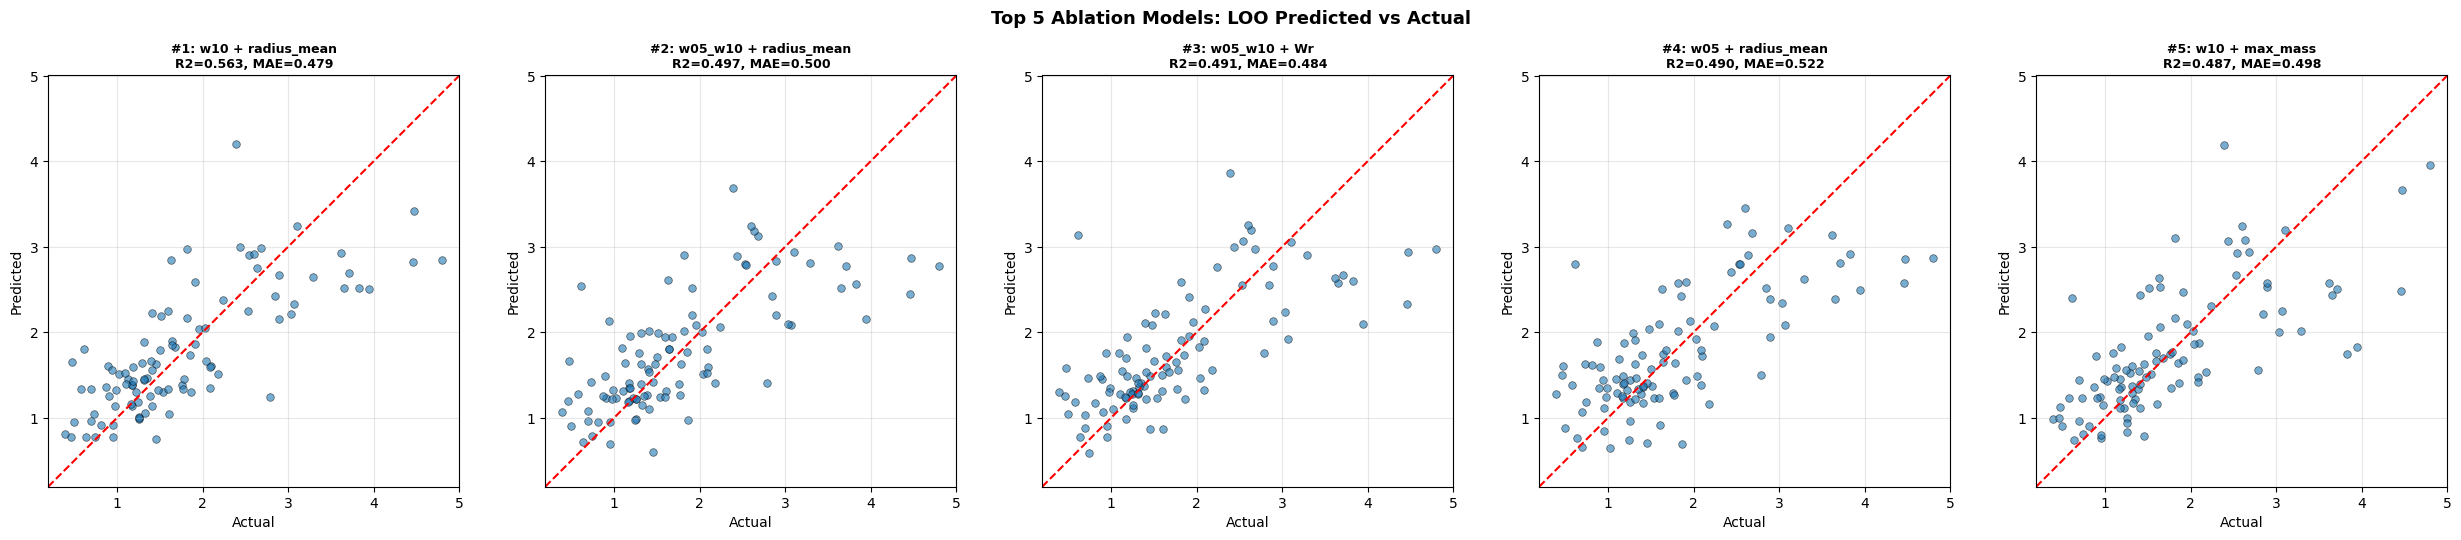

In [10]:
# ============================================================
# PRED vs ACTUAL SCATTER FOR TOP 5 ABLATION MODELS
# ============================================================
# Sort ablation results by LOO_R2
df_abl_sorted = pd.DataFrame(ablation_results).sort_values('LOO_R2', ascending=False)
top_n = min(5, len(df_abl_sorted))

fig, axes = plt.subplots(1, top_n, figsize=(5*top_n, 5))
if top_n == 1:
    axes = [axes]

for idx in range(top_n):
    row = df_abl_sorted.iloc[idx]
    csv_path = os.path.join(CSV_DIR, row['csv'])
    feat_cols = row['features']
    
    df_data = pd.read_csv(csv_path)
    # Check all feature cols exist
    feat_cols = [c for c in feat_cols if c in df_data.columns]
    
    X = df_data[feat_cols].values
    y = df_data['alpha_R'].values
    valid = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[valid], y[valid]
    
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=1.0, reg_lambda=1.0, random_state=42, verbosity=0)
    
    y_pred = np.zeros(len(y))
    loo = LeaveOneOut()
    for tr, te in loo.split(X):
        model.fit(X[tr], y[tr])
        y_pred[te] = model.predict(X[te])
    
    ax = axes[idx]
    ax.scatter(y, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=30)
    lims = [min(y.min(), y_pred.min()) - 0.2, max(y.max(), y_pred.max()) + 0.2]
    ax.plot(lims, lims, 'r--', lw=1.5)
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    
    label = row['csv'].replace('desc_E_enhanced_','').replace('.csv','') + ' + ' + row['added']
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    ax.set_title(f'#{idx+1}: {label}\nR2={r2:.3f}, MAE={mae:.3f}', fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle('Top 5 Ablation Models: LOO Predicted vs Actual', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(CSV_DIR, 'top5_pred_vs_actual.png'), dpi=150, bbox_inches='tight')
plt.show()
